In [1]:
#Código necessário

import numpy as np
import matplotlib.pyplot as plt

def Assembly(conec, C):
    #Procura o maior valor entre o maior valor de cada coluna, assim encontrando o tamanho
    nv = max([max(conec[:,0]), max(conec[:,1])])
    #Quantidade de canos = número de ligações = tamanho da lista de Condutâncias
    nc = len(C)
    A = np.zeros(shape=(nv,nv))
    #Para cada cano
    for k in range(nc):
        #Pega os nós conectados
        n1 = conec[k, 0] - 1
        n2 = conec[k, 1] - 1

        #Salva na matriz A os valores da condutância do cano de acordo com os nós respectivos
        A[n1, n1] += C[k]
        A[n1, n2] += -C[k]
        A[n2, n1] += -C[k]
        A[n2, n2] += C[k]

    return A

#Para calcular as pressões de cada nó e vazões de cada cano
def SolveNetwork(conec, C, natm, nB, QB, imprimir):
    #Procura o maior valor entre o maior valor de cada coluna, assim encontrando o tamanho
    nv = max([max(conec[:,0]), max(conec[:,1])])

    #Pega a matriz A
    Atilde = Assembly(conec, C)
    #Altera a linha do nó de saída da massa
    Atilde[natm-1, :] = 0
    Atilde[natm-1, natm-1] = 1

    #Cria a matriz de variação da massa
    b = np.zeros(shape=nv)
    #Salva em qual nó está entrando massa externa
    b[nB-1] = QB

    #Resolve a matriz, assumindo Ã como dados, b como resultados e calculando o vetor de pressões intermediário
    pressure = np.linalg.solve(Atilde, b)

    #Para não desacelerar desnecessariamente o último exercício
    if imprimir:
        print("Ã = ", Atilde, "\n\nb = ", b, "\n\nPressão = ", pressure)
    return pressure

def GeraRede(nx,ny,CH,CV):
    nv = nx*ny
    nc = (nx-1)*ny + (ny-1)*nx
    
    coord = np.zeros(shape=(nv,2))

    for i in range(nx):
      for j in range(ny):
        ig = i + j*nx
        coord[ig,0] = i
        coord[ig,1] = j

    conec = np.zeros(shape=(nc,2), dtype=int)
    C = np.zeros(nc)
    
    # Loop sobre canos horizontais
    for j in range(ny):
        for i in range(nx-1):
          k = j*(nx-1) + i
          conec[k,0] = j*nx + i
          conec[k,1] = j*nx + i+1
          C[k] = CH

    # Loop sobre canos verticais
    for i in range(nx):
      for j in range(ny-1):
          k = (nx-1)*ny + j*nx + i
          conec[k,0] = i + j*nx
          conec[k,1] = i + (j+1)*nx
          C[k] = CV

    return nv, nc, conec, C, coord

def PlotPressure(nx, ny, pressure):
    x = np.arange(0, nx, 1)
    y = np.arange(0, ny, 1)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(pressure)
    Z.shape = (ny,nx)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Contours of pressure')
    ax.grid()
    ax.set_xticks(x)
    ax.set_yticks(y)
    cp = plt.contourf(X, Y, Z, cmap='jet')
    cb = plt.colorbar(cp)
    plt.show()

def PlotPressureAsSurface(nx, ny, pressure):
    x = np.arange(0, nx, 1)
    y = np.arange(0, ny, 1)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(pressure)
    Z.shape = (ny,nx)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Contours of pressure')
    ax.grid()
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax = plt.axes(projection="3d")
    ax.plot_surface(X, Y, Z, cmap='jet', edgecolor=None)
    ax.set(xlabel='$x$', ylabel='$y$', zlabel='$z$')
    ax.view_init(elev=30., azim=45)
    plt.show()

In [2]:
def RandomFailFinos(C, po, Centup):
    Cnew = np.copy(C)
    nc = len(C)
    for k in range(nc):
        x = np.random.rand()
        if x <= po and Cnew[k] == 2:
            Cnew[k] = Centup

    return Cnew

def CalcularProbabilidade(qtdCasos, po, Centup):
    #Formar a rede base
    CH = 2.0
    CV = 2.0
    nx, ny = 10, 10
    nv, nc, conec, C, coord = GeraRede(nx, ny , CH, CV)

    #Canos grossos
    lst = [0, 1, 2, 30, 31, 32, 93, 103, 113]
    C[lst] = 20.0

    #O código foi projetado para o primeiro nó ser o 1, então aumenta o valor de todos em 1
    conec[:][:] += 1

    qtdCasosPressao = 0

    for i in range(int(qtdCasos)):
        Cnovo = RandomFailFinos(C, po, Centup)
        p = SolveNetwork(conec, Cnovo, nx*ny, 1, 10, False)
        if max(p) >= 12:
            qtdCasosPressao += 1

    return qtdCasosPressao/qtdCasos

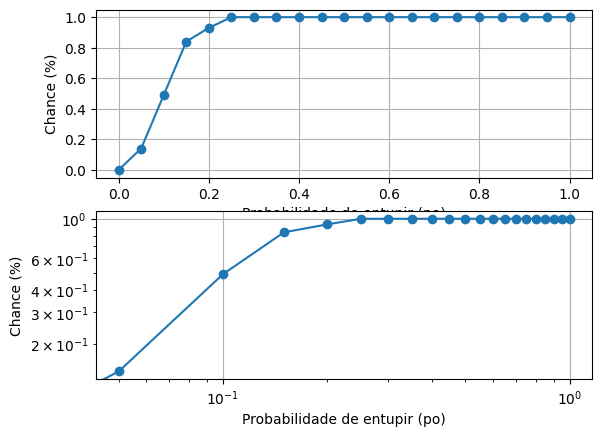

In [3]:
pOs = np.linspace(0, 1, 21)
probabilidades = []

for i in pOs:
    probabilidades.append(CalcularProbabilidade(10**2, i, 0.2))

fig, ax = plt.subplots(2)
ax[0].plot(pOs, probabilidades, marker='o')
ax[0].grid()
ax[0].set_ylabel('Chance (%)')
ax[0].set_xlabel('Probabilidade de entupir (po)')

ax[1].plot(pOs, probabilidades, marker='o')
ax[1].loglog()
ax[1].grid()
ax[1].set_ylabel('Chance (%)')
ax[1].set_xlabel('Probabilidade de entupir (po)')

plt.show()